In [1]:
import numpy as np
import os
import argparse

import math
import json
import numpy as np 
import scipy
import matplotlib.pylab as plt

import copy
import random

from random import randrange
from scipy.optimize import minimize 

import random
SEED = 66
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
def init_vector(dim, norm):
    vec = 2 * np.random.rand(dim) - 1.
    return vec * norm / math.sqrt(dim)

def init_arms(dim, norm, num):
    decision = np.random.rand(num, dim)
    for i in range(num):
        decision[i] = init_vector(dim, norm)
    return decision

def func(x):
     return x
dim = 10
sigma= 1
corruption = 0
T= 1000
repeat = 10
repeat_time= repeat
actions = 20
norm = 1
bmu = np.ones(dim)/ math.sqrt(dim)
print(bmu)




[0.31622777 0.31622777 0.31622777 0.31622777 0.31622777 0.31622777
 0.31622777 0.31622777 0.31622777 0.31622777]


In [2]:
from scipy.stats import t as t_dist
def reward_function(chosen_arm, theta_star, flag,df=3, scale=1):
    expected_payoff = func(chosen_arm.dot(theta_star))

    noise = t_dist.rvs(df=df) * scale 
    
    if flag==0:
        observed_payoffs = expected_payoff + noise
    else:
        observed_payoffs = -expected_payoff + noise
    return observed_payoffs
    

In [3]:

from scipy.integrate import quad  
  
def z_s(u, y_s, sigma_s, f):  
    return (y_s - f(u)) / sigma_s  

# Define the loss function.
def objective_function(theta, lambda_k, B, k, t, phi_s, y_s, sigma_s, tau_s, f):  
   
    loss = lambda_k * k / 2 * np.linalg.norm(theta)**2  
    
    
    for s in range(1, t+1 ):  
        
        integral_func = lambda u: (tau_s[s] * z_s(u, y_s[s], sigma_s[s], f)) / np.sqrt(tau_s[s]**2 + z_s(u, y_s[s], sigma_s[s], f)**2)  
        integral_result, _ = quad(integral_func, 0, np.dot(phi_s[s], theta))  
        loss += -1 / sigma_s[s] * integral_result  
        
    return loss 


# Define the gradient of the loss function.
def gradient_function(theta, lambda_k, B, k, t, phi_s, y_s, sigma_s, tau_s, f):  
    grad = lambda_k * k * theta  
    for s in range(1, t + 1):  
        z_s_at_upper_limit = z_s(np.dot(phi_s[s], theta), y_s[s], sigma_s[s], f)  
        grad_term = (tau_s[s] * z_s_at_upper_limit) / np.sqrt(tau_s[s]**2 + z_s_at_upper_limit**2)  
        grad_integral_part = -1 / sigma_s[s] * phi_s[s] * grad_term
        grad = grad + grad_integral_part  
    return grad  
     
def constraint12(theta):
     return 1 - np.linalg.norm(theta)

def project_to_unit_ball(theta):  

    norm = np.linalg.norm(theta)  
    if norm > 1:  
        return theta / norm  
    else:  
        return theta  

In [4]:
for jjjj in range(repeat):
    
    number =  jjjj-repeat_time*int(jjjj /repeat_time)
    print(corruption, number)
    cur_crr = 0
    decision_t = init_arms(dim, norm, actions)
    
    LAMBDA = 1
    beta=1.5
    alpha=0.2
    SIGMA = LAMBDA*np.diag(np.ones(dim))
    BB = np.zeros(dim)
    REGRET = 0
    TOTALREGRET = []
    for t in range(T):
        weight = 1
        noise= t_dist.rvs(df=3, size=actions)   * sigma
        flag = 0
        if cur_crr < corruption:
       
            flag = 1

        decision = init_arms(dim, norm, actions)
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")
        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)
        if flag == 1:
            cur_crr += 1
            for arm in range(actions):
                reward[arm] = noise[arm] - np.dot(decision[arm], bmu)
        hattheta = np.linalg.lstsq(SIGMA[:,:], BB[:], rcond=-1)
        hattheta = hattheta[0]
        hattheta.shape = (dim)
        MAX_R = float("-inf")
        for a_t in range(actions):
            action_t = decision[a_t]
            UU=np.linalg.lstsq(SIGMA[:,:], action_t, rcond=-1)
            UU= UU[0]
            UU.shape = (dim)
            r_action_t = np.dot(action_t, hattheta) + beta * np.sqrt(np.dot(UU,action_t))
            if MAX_R < r_action_t: 
                MAX_R = r_action_t
                final_a_t = a_t
                action = action_t
                weight = min(1,alpha/np.sqrt(np.dot(UU,action_t)))
        REGRET += func(optimal_reward) - func(np.dot(action, bmu))
        SIGMA[:,:]  = SIGMA[:,:] + weight*np.mat(action).T * np.mat(action)
        BB[:] = BB[:] + weight*reward[final_a_t] * action
        TOTALREGRET.append(REGRET)
    path  = "AdditiveC_lowerbound_" + str(number) +"_"+ str(corruption)+".txt"
    fr = open(path,'w')
    for i in TOTALREGRET:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9


In [5]:
for jjjj in range(repeat):
    
    number =  jjjj-repeat_time*int(jjjj /repeat_time)
    print(corruption, number)
    cur_crr = 0
    decision_t = init_arms(dim, norm, actions)
    
    LAMBDA = 1
    beta=10
    alpha=1
    SIGMA = LAMBDA*np.diag(np.ones(dim))
    BB = np.zeros(dim)
    REGRET = 0
    TOTALREGRET = []
    for t in range(T):
        noise= t_dist.rvs(df=3, size=actions)   * sigma
        
        flag = 0
        if cur_crr < corruption:
            decision = init_arms(dim, norm, actions)
            if cur_crr < corruption:
                flag = 1
        else:
            decision = decision_t
       
        decision = init_arms(dim, norm, actions)
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")
        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)
        if flag == 1:
            cur_crr += 1
            for arm in range(actions):
                reward[arm] = noise[arm] - np.dot(decision[arm], bmu)
        hattheta = np.linalg.lstsq(SIGMA[:,:], BB[:], rcond=-1)
        hattheta = hattheta[0]
        hattheta.shape = (dim)
        MAX_R = float("-inf")
        for a_t in range(actions):
            action_t = decision[a_t]
            r_action_t = np.dot(action_t, hattheta)
            if MAX_R < r_action_t: 
                MAX_R = r_action_t
                final_a_t = a_t
                action = action_t
        REGRET += func(optimal_reward) - func(np.dot(action, bmu))
        SIGMA[:,:]  = SIGMA[:,:] + np.mat(action).T * np.mat(action)
        BB[:] = BB[:] + reward[final_a_t] * action
        TOTALREGRET.append(REGRET)
    path  = "Greedy_lowerbound_" + str(number) +"_"+ str(corruption)+".txt"
    fr = open(path,'w')
    for i in TOTALREGRET:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9


In [6]:
for jjjj in range(repeat):
    
    number =  jjjj-repeat_time*int(jjjj /repeat_time)
    print(corruption, number)
    cur_crr = 0
    decision_t = init_arms(dim, norm, actions)
   
    LAMBDA = 1
    beta=1
    alpha=1
    SIGMA = LAMBDA*np.diag(np.ones(dim))
    BB = np.zeros(dim)
    REGRET = 0
    TOTALREGRET = []
    for t in range(T):
        noise= t_dist.rvs(df=3, size=actions)   * sigma
       
        flag = 0
        if cur_crr < corruption:
            decision = init_arms(dim, norm, actions)
            if cur_crr < corruption:
                flag = 1
        else:
            decision = decision_t
       
        decision = init_arms(dim, norm, actions)
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")
        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)
        if flag == 1:
            cur_crr += 1
            for arm in range(actions):
                reward[arm] = noise[arm] - np.dot(decision[arm], bmu)
        hattheta = np.linalg.lstsq(SIGMA[:,:], BB[:], rcond=-1)
        hattheta = hattheta[0]
        hattheta.shape = (dim)
        MAX_R = float("-inf")
        for a_t in range(actions):
            action_t = decision[a_t]
            UU=np.linalg.lstsq(SIGMA[:,:], action_t, rcond=-1)
            UU= UU[0]
            UU.shape = (dim)
            r_action_t = np.dot(action_t, hattheta) + beta * np.sqrt(np.dot(UU,action_t))
            if MAX_R < r_action_t: 
                MAX_R = r_action_t
                final_a_t = a_t
                action = action_t
        REGRET += func(optimal_reward) - func(np.dot(action, bmu))
        SIGMA[:,:]  = SIGMA[:,:] + np.mat(action).T * np.mat(action)
        BB[:] = BB[:] + reward[final_a_t] * action
        TOTALREGRET.append(REGRET)
    path  = "OFUL_lowerbound_" + str(number) +"_"+ str(corruption)+".txt"
    fr = open(path,'w')
    for i in TOTALREGRET:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 
    

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9


In [7]:
import numpy as np
from scipy.optimize import minimize

def run_experiment(
    T, B,L,k,K,dim, norm, actions, corruption, sigma, bmu, func,
    reward_function, objective_function, gradient_function, constraint12,
    repeat_index, repeat_time,
):
    number = repeat_index - repeat_time * int(repeat_index / repeat_time)
    print(corruption, number)

    cur_crr = 1
    
    lambda_=20
    tau_0=1
    m_0=1.5
    alpha=max(1 , corruption**0.5)
    H = np.eye(dim) * lambda_
    theta = np.zeros(dim)
    beta=0.6

    sigma_min = 1 / np.sqrt(T)

    
    sigma_ = [None] * (T + 1)
    w_ = [None] * (T + 1)
    tau_ = [None] * (T + 1)
    y_ = [None] * (T + 1)
    var_ = [None] * (T + 1)
    phi_ = [None] * (T + 1)
    theta_history = []
    REGRET = 0
    TOTALREGRET = []

    for t in range(1, T + 1):
        noise= t_dist.rvs(df=3, size=actions)   * sigma

        flag = 0
        if cur_crr < corruption:
            flag = 1

        decision = init_arms(dim, norm, actions)
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")

        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)

        if flag == 1:
            cur_crr += 1
            for arm in range(actions):
                reward[arm] = noise[arm] - np.dot(decision[arm], bmu)

        max_dot_product = float('-inf')
        best_i = None

        for i in range(actions):
            def objective(theta_):
                return -np.dot(decision[i], theta_)

            def constraint1(theta_):
                return B - np.linalg.norm(theta_)

            def constraint2(theta_):
                return beta - np.sqrt(np.dot(np.dot(theta_ - theta, H), theta_ - theta))

            theta0 = np.zeros_like(theta)
            cons = [{'type': 'ineq', 'fun': constraint1}, {'type': 'ineq', 'fun': constraint2}]
            result = minimize(objective, theta0, constraints=cons)
            optimal_value = -result.fun

            if optimal_value > max_dot_product:
                max_dot_product = optimal_value
                best_i = i

        phi_[t] = decision[best_i]

        REGRET += func(optimal_reward) - func(np.dot(phi_[t], bmu))
        phi_t_H_inv_norm = np.sqrt(np.dot(np.dot(phi_[t], np.linalg.inv(H)), phi_[t]))

        y_[t] = reward_function(phi_[t], bmu, flag)

        var_[t] = sigma
        sigma_candidates = [
        var_[t],                                        # noise variance
        sigma_min,                                      # min bound
        phi_t_H_inv_norm / m_0,                         # norm-based
        alpha * (phi_t_H_inv_norm ** 0.5)        ]

        sigma_[t] = max(sigma_candidates)

        w_[t] = phi_t_H_inv_norm / sigma_[t]
        tau_[t] = tau_0 * np.sqrt(1 + w_[t] ** 2) / w_[t]

        theta = minimize(
            fun=objective_function,
            x0=theta,
            args=(lambda_, B, k, t, phi_, y_, sigma_, tau_, func),
            jac=gradient_function,
            constraints=[{'type': 'ineq', 'fun': constraint12}]
        ).x

        H += np.outer(phi_[t], phi_[t]) / (sigma_[t] ** 2)
        
      
        TOTALREGRET.append(REGRET)

    return TOTALREGRET


In [8]:
for jjjj in range(repeat):
    regret_list = run_experiment(
            T=T,
            B=1,
            L=1,
            k=1,
            K=1,
            dim=dim,
            norm=norm,
            actions=actions,
            corruption=corruption,
            sigma=sigma,
            bmu=bmu,
            func=func,
            reward_function=reward_function,
            objective_function=objective_function,
            gradient_function=gradient_function,
            constraint12=constraint12,
            repeat_index=jjjj,
            repeat_time=repeat

    )
    
    number = jjjj - repeat_time * int(jjjj / repeat_time)
    path = f"GADA_lowerbound_{number}_{corruption}.txt"
    
    with open(path, "w") as fr:
        for regret in regret_list:
            fr.write(f"{regret}\n")


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9


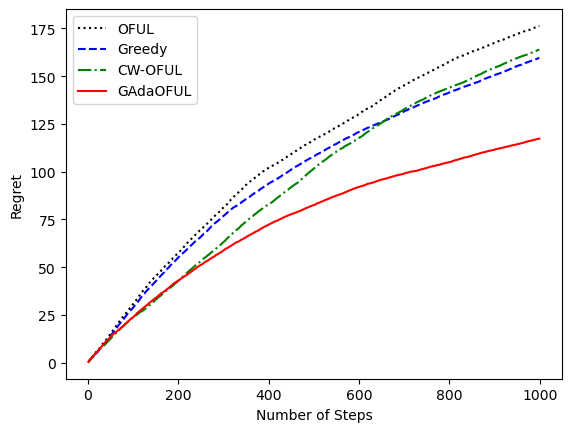

In [10]:
number = corruption
repeat = 10


rewardrobust = np.zeros(T+1)
rewardgreedy = np.zeros(T+1)
rewardOFUL = np.zeros(T+1)
rewardgada=np.zeros(T+1)
rewardADA=np.zeros(T+1)
rewardADAD=np.zeros(T+1)
finalrewardrobust = np.zeros(11)
finalrewardgreedy = np.zeros(11)
finalrewardOFUL = np.zeros(11)
for jjjj in range(repeat):
    line1=0
    path  = "AdditiveC_lowerbound_" + str(jjjj) +"_"+ str(number)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardrobust[line1]=rewardrobust[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardrobust[i] = rewardrobust[i]/repeat



for jjjj in range(repeat):
    line1=0
    path  = "Greedy_lowerbound_" + str(jjjj) +"_"+ str(number)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardgreedy[line1]=rewardgreedy[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardgreedy[i] = rewardgreedy[i]/repeat

for jjjj in range(repeat):
    line1=0
    path  = "GADA_lowerbound_" + str(jjjj) +"_"+ str(number)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardgada[line1]=rewardgada[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardgada[i] = rewardgada[i]/repeat

for jjjj in range(repeat):
    line1=0
    path  = "OFUL_lowerbound_" + str(jjjj) +"_"+ str(number)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardOFUL[line1]=rewardOFUL[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardOFUL[i] = rewardOFUL[i]/repeat

'''
for jjjj in range(repeat):
    line1=0
    path  = "ADA_lowerbound_" + str(jjjj) +"_"+ str(number)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardADA[line1]=rewardADA[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardADA[i] = rewardADA[i]/repeat
'''   


x=list(range(1, T))

x=list(range(1,T))
plt.plot(x, rewardOFUL[0:T-1],color='black', label='OFUL',linestyle=":")
    
x=list(range(1, T))
plt.plot(x, rewardgreedy[0:T-1],color='blue', label='Greedy',linestyle= "--")

x=list(range(1, T))
plt.plot(x, rewardrobust[0:T-1],color='green', label='CW-OFUL',linestyle= "-.")
x=list(range(1, T))
plt.plot(x, rewardgada[0:T-1],color='red', label='GAdaOFUL',linestyle= "-")
linestyle= (0, (5, 1))

plt.legend(fontsize=10)
plt.xlabel('Number of Steps',size=10)
plt.ylabel('Regret',size=10)

plt.savefig('lin.pdf', dpi=300)
plt.show()
